# makemore_Backprop

----
* Inspired by Andrej Karpathy's ["Building makemore Part 4: Becoming a Backprop Ninja"](https://www.youtube.com/watch?v=q8SA3rM6ckI&t=6s)

* Supplementary links 
    - 'Yes you should understand backprop' - Karpathy, Dec 2016 [blog link](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)
    - [BatchNorm paper](https://arxiv.org/abs/1502.03167)
    - [Bessel's Correction](https://math.oxford.emory.edu/site/math117/besselCorrection/)
    - Bengio et al. 2003 MLP language model paper [(pdf)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

# Table of Contents
------------------
- [0. Makemore: Introduction](#0)
- [1. Starter Code](#1)
- [2. Exercise 1: Backpropagation through the Atomic Compute Graph](#2)
- [3. Bessel's Correction in `BatchNorm`](#3)
- [4. Exercise 2: Cross Entropy Loss Backward Pass](#4)
- [5. Exercise 3: `BatchNorm` Layer Backward Pass](#5)
- [6. Exercise 4: Putting it all Together](#6)
- [7. Conclusion](#7)
------



# Appendix
---------------
- [A1. Linear Layer Manual Backpropagation: Simpler Case](#a1)
- [A2. Broadcasting Examples: Simpler Cases](#a2)

## [References](#r1)

-----------
<br><br>
# 0. Makemore: Introduction<a id="0"></a>
---------------------------------
<u>**Makemore**</u> takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an **autoregressive character-level language model**, with a <u>wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT)</u>. An [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble. 
```
"As the name suggests, makemore makes more."
```
This is not meant to be too heavyweight of a library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. [PyTorch](https://pytorch.org) is the only requirement.

Current implementation follows a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)


In the 3rd makemore tutorial notebook, we covered key concepts for training neural networks, including forward pass activations, backward pass gradients, and batch normalization, with a focus on implementing and optimizing MLPs and ResNets in `PyTorch`. We also introduced diagnostic tools to monitor neural network health and highlights important considerations like proper weight initialization and learning rate selection.



In this notebook, we take the **2-layer MLP (with BatchNorm)** from the previous video and **backpropagate through it <u>manually</u> without using `PyTorch` autograd's `loss.backward()` through the cross entropy loss, 2nd `Linear` layer, `tanh`, `batchnorm`, 1st `Linear` layer, and the embedding table.** Along the way, we get a strong intuitive understanding about how gradients flow backwards through the compute graph and on the level of efficient Tensors, not just individual scalars like in **micrograd.** This helps build competence and intuition around how neural nets are optimized and sets you up to more confidently innovate on and debug modern neural networks.

---------
<br><br><a id="1"></a>
# 1. Starter Code
-----
Let's recap the MLP model we implemented in **part 2 & 3 (MLP) of the makemore series**.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


----
`cmp` will be used to compare and check manual gradients to `PyTorch` gradients.

In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

----
We'll implement a significantly expanded version of forward pass because:
* full explicit implementation of loss function instead of using `F.cross_entropy`
* break-up of implementation into manageable chunks
    - allows for step-by-step backward calculation of gradients from bottom to top (upwards)

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability (so exponential does not explode)
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3514, grad_fn=<NegBackward0>)

---------
<br><br><a id="2"></a>
# 2.  Exercise 1: Backpropagation through the Atomic Compute Graph
-----
The goal is to manually calculate the loss gradient $w.r.t$ to all the preceding parameters step-by-step. Let's go through each parameter. [Note: `di = dloss/di` for all network parameters]
* `dlogprobs` = `torch.zeros_like(logprobs)` $\rightarrow$ `dlogprobs[range(n), Yb]` = `-1.0/n`
    - to calculate`loss`, we choose only the target characters from the `logprobs` matrix. Thus, only those positions (target positions) will be affected by the backprop. Since we average across the mini-batches, we must divide by the mini-batch size (`n` = $32$).
    - simpler example: using `loss = -(a+b+c)/3` where `n` = $3$, `dloss/da = dloss/db = dloss/dc = -1/3`
    - see [Appendix A2](#a2) for broadcasting guidance.
<br><br>   
* `dprobs` = `(1/probs) * dlogprobs` 
    - this basically either passes the `dlogprobs` if the `prob` is significantly close to $1$ (correct predictions) or boosts the gradients of incorrectly-assigned probabilities (correct character with a low `prob` = incorrect predictions).
    - using $\boldsymbol{\frac{dln(x)}{dx} = \frac{1}{x}}$  and <u>chain rule</u>: $\boldsymbol{\frac{dy}{dx} = \frac{dln(x)}{dx} \times \frac{dy}{dln(x)}}$
<br><br>    
* `dcounts_sum_inv` = `(counts * dprobs).sum(1, keepdim = True)`
    - `counts_sum_inv` is a $[32, 1]$ matrix and `counts` is a $[32, 27]$ matrix. There is a **broadcasting** happening under the hood. Let's look at a simple example. <br><img src="_imgs/dcounts_sum_inv_broadcasting.png" alt="broadcasting" width="500" ><br> Since $b1$ appears in two places of the resulting matrix, we must accumulate the gradients. Thus, we must sum the gradient matrix across the rows (`.sum(1, keepdim = True)`).
    - Remember: **Broadcasting in the forward pass creates a summation in the backward pass.** See [Appendix A2.](#a2)
    - using $\boldsymbol{f = a\times b, \frac{df}{da} = b}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{da} = \frac{df}{da} \times \frac{dy}{df}}$
  <br><br>  
* `dcounts_sum` = `(-counts_sum**-2) * dcounts_sum_inv`
    - using $\boldsymbol{\frac{dx^n}{dx} = nx^{(n-1)}}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{dx} = \frac{dx^n}{dx} \times \frac{dy}{dx^n}}$
<br><br>    
* `dcounts` = `dprobs * counts_sum_inv`$\rightarrow$ `dcounts += torch.ones_like(counts)* dcounts_sum`
    - using  $\boldsymbol{f = a\times b, \frac{df}{da} = b}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{da} = \frac{df}{da} \times \frac{dy}{df}}$
    - `count` contributes to the derivative in two paths shown below. Thus, we must add both derivatives. In `counts_sum`, we sum `count` across the rows. **Summation in the forward pass means broadcasting in the backward pass.** See [Appendix A2.](#a2)<br>
        ```
        >>>probs = counts * counts_sum_inv
        >>>counts_sum = counts.sum(1, keepdims=True)
        ```
    - The code above shows the relevant section(s) of the forward pass pertaining to `counts`
<br><br>
* `dnorm_logits` = `norm_logits.exp() * dcounts`
    - using $\boldsymbol{\frac{de^{x}}{dx} = e^{x}}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{dx} = \frac{de^x}{dx} * \frac{dy}{de^x}}$
<br><br> 
* `dlogit_maxes` = `(-1.0 * dnorm_logits).sum(1, keepdim = True)`
    - using $\boldsymbol{f = a - b, \frac{df}{db} = -1}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{db} = \frac{df}{db} \times \frac{dy}{df}}$
    - The shapes of `logits` and `logit_maxes` are $[32, 27]$ and $[32, 1]$ respectively. The `logit_maxes` matrix is **broadcasted across the rows.** Thus, we must accumulate the gradients (sum gradient matrix across the rows). Since, this is a simple addition, the gradient directly flows.
    - `logit_maxes` does not affect the overall distribution of the probabilities and is only used for numerical stability. Thus, `dlogit_maxes` must be very close to $0$.
<br><br>     
* `dlogits` = `1 * dnorm_logits` $\rightarrow$ `dlogits += F.one_hot(logits.max(1).indices, num_classes = 27) * dlogit_maxes`
    - using $\boldsymbol{f = a - b, \frac{df}{da} = 1}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{da} = \frac{df}{da} \times \frac{dy}{df}}$
    - Logits affects the forward pass in two ways.<br>
        ```
        >>>logit_maxes = logits.max(1, keepdim=True).values
        >>>norm_logits = logits - logit_maxes
        ```
    - `.max` function gives us both maximum values and their positions. Only the maximum values will be affected through `logit_maxes`. 
    - See [Appendix A2.](#a2)
<br><br>     
* `dh` = `dlogits @ W2.T`, `dW2` = `h.T @ dlogits`, `db2` = `dlogits.sum(0)`
    - See [Appendix A1.](#a1)
<br><br>    
* `dhpreact` = `(1 - h**2) * dh`
    - using $\boldsymbol{f = \tanh(x), \frac{df}{dx} = 1 - f^2(x)}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{dx} = \frac{df}{dx} \times \frac{dy}{df}}$
<br><br> 
* `dbngain` = `(bnraw * dhpreact).sum(0, keepdim=True)` $\rightarrow$ `dbnbias` = `(1 * dhpreact).sum(0, keepdim=True)`
    - `bngain` and `bnbias` are both $[1, 64]$ matrices. `bnraw` is a $[32, 64]$ matrix. Both `bngain` and `bnbias` matrices are **broadcasted across the columns.** Thus, we must accumulate the gradients (sum gradient matrix across the columns). 
    - using $\boldsymbol{f = (a\times b) + c, \frac{df}{da} = b, \frac{df}{dc} = 1}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{da} = \frac{df}{da} \times \frac{dy}{df}}$, $\boldsymbol{\frac{dy}{dc} = \frac{df}{dc} \times \frac{dy}{df}}$
<br><br> 
* `dbnraw` = `bngain * dhpreact`
    - using $\boldsymbol{f = (a\times b), \frac{df}{da} = b}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{da} = \frac{df}{da} \times \frac{dy}{df}}$
<br><br> 
* `dbnvar_inv` = `(bndiff * dbnraw).sum(0, keepdim=True)`
    - `bnvar_inv` is a $[1, 64]$ matrix and `bndiff` is a $[32, 64]$ matrix. So `bnvar_inv` matrix is **broadcasted across the columns.** Thus, we must accumulate the gradients (sum gradient matrix across the columns). 
    - using $\boldsymbol{f = (a\times b), \frac{df}{da} = b}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{da} = \frac{df}{da} \times \frac{dy}{df}}$
<br><br> 
* `dbnvar` = `-0.5*(bnvar + 1e-5)**(-1.5) * dbnvar_inv`
    - using $\boldsymbol{\frac{dx^n}{dx} = nx^{(n-1)}}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{dx} = \frac{dx^n}{dx} \times \frac{dy}{dx^n}}$
<br><br> 
* `dbndiff2` = `(1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar`
    - using $\boldsymbol{f = \frac{a}{const + 1}, \frac{df}{da} = \frac{1}{const + 1}}$ and <u>chain rule</u>: $\boldsymbol{\frac{dy}{da} = \frac{df}{da} \times \frac{dy}{df}}$
    - `bndiff2` is a $[32, 64]$ matrix and `bnvar` is a $[1, 64]$ matrix. Thus, we must add both derivatives. In `bnvar`, we sum `bndiff2` across the rows. **Summation in the forward pass means broadcasting in the backward pass.** We can use a <u>ones matrix to implement the broadcasting operation.</u><br>
        ```
        >>>bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
        ```
    - The code above shows the relevant section(s) of the forward pass pertaining to `bndiff2`
<br><br> 
* `dbndiff` = `(bnvar_inv * dbnraw) + (2 * bndiff * dbndiff2)`
    - `bndiff` contributes to the derivative in two paths shown below, therefore we must add both derivatives. Recall the <u>multivariate chain rule:</u> $\boldsymbol{ \frac{df}{dt} = \frac{df}{da}\frac{da}{dt} + \frac{df}{db}\frac{db}{dt}  }$ <br>
        ```
        >>>bndiff2 = bndiff**2
        >>>bnraw = bndiff * bnvar_inv
        ```
    - The code above shows the relevant section(s) of the forward pass pertaining to `bndiff`
<br><br> 
* `dbnmeani` = `(-1.0 * dbndiff).sum(0, keepdim=True)`
    - see `dbnbias` and `dbnvar_inv` sections for reference
<br><br>
* `dhprebn` = `1.0 * dbndiff` $\rightarrow$ `dhprebn += (1.0/n) * torch.ones_like(hprebn) * dbnmeani`
    - see `dlogits` and `dbndiff2` sections for reference
<br><br>
* `dembcat` = `dhprebn @ W1.T`, `dW1` = `embcat.T @ dhprebn`, `db1` = `dhprebn.sum(0)`
    - See [Appendix A1.](#a1) 
<br><br>
* `demb` = `dembcat.view(emb.shape)`
    - We need to unpack the gradients since we have concatenated the embeddings. We can use the `.view` operation.<br>
        ```
        >>>embcat = emb.view(emb.shape[0], -1) 
        ```
    - The code above shows the relevant section of the forward pass pertaining to `emb`
<br><br> 
* `dC` 
    - This gradient was a bit more tricky. We basically have to flow back the embedding gradients to the original embedding space.
    - `emb.shape = [32,3,10]` and `C.shape = [27,10]`. 
    - One way to handle this is by <u>iterating through the rows and columns of `Xb` to map every embedding gradient to the corresponding embedding.</u> 
    - Also bear in mind, some embedding locations might appear multiple times so we have to sum the gradients in those cases. 

In [9]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [10]:
logprobs.shape

torch.Size([32, 27])

In [11]:
logprobs[range(n), Yb]

tensor([-3.9346, -3.1014, -3.6580, -3.3507, -4.0988, -3.4880, -3.2290, -4.0731,
        -3.2338, -4.2270, -3.1196, -1.7151, -2.7638, -3.0241, -2.9716, -3.2359,
        -3.7394, -3.0354, -3.5403, -3.3955, -2.8156, -3.0766, -4.2790, -3.9457,
        -3.5833, -2.8992, -3.0532, -3.8914, -2.8200, -3.5050, -3.3221, -3.1180],
       grad_fn=<IndexBackward0>)

In [12]:
logprobs[range(n), Yb].shape

torch.Size([32])

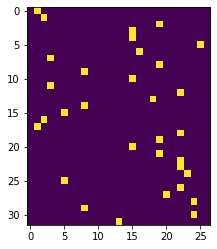

In [13]:
# see where the max values are located
plt.imshow(F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]))

In [14]:
#counts.shape, counts_sum_inv.shape, dprobs.shape

In [15]:
counts_sum.shape, counts.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

In [16]:
norm_logits.shape, logit_maxes.shape, logits.shape

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 27]))

In [17]:
#dlogits.shape, h.shape, W2.shape, b2.shape

In [18]:
#dhpreact.shape, bngain.shape, bnbias.shape, bnraw.shape, (bngain * dhpreact).shape

In [19]:
#bnraw.shape, bndiff.shape, bnvar_inv.shape, (bndiff*dbnraw).sum(0, keepdim=True).shape

In [20]:
#bnvar_inv.shape, bnvar.shape,(-0.5*bnvar_inv**3 * dbnvar_inv).shape

In [21]:
bnvar.shape, bndiff2.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [22]:
#bndiff.shape, (bnvar_inv * dbnraw).shape, (2*bndiff*dbndiff2).shape

In [23]:
#bndiff.shape, hprebn.shape, bnmeani.shape, (-1*dbndiff).sum(0, keepdim=True).shape

In [24]:
#bnmeani.shape, hprebn.shape, (torch.ones_like(hprebn)*dbndiff).shape, ((1.0/n) * torch.ones_like(hprebn) * dbnmeani).shape

In [25]:
# hprebn.shape, \
# embcat.shape, (dhprebn @ W1.T).shape, \
# W1.shape, (embcat.T @ dhprebn).shape, \
# b1.shape, dhprebn.sum(0).shape

In [26]:
#embcat.shape, emb.shape, dembcat.view(emb.shape).shape

In [27]:
#emb.shape, C.shape, Xb.shape, demb.shape

In [28]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True)
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts)* dcounts_sum
dnorm_logits = norm_logits.exp() * dcounts
dlogit_maxes = (-1.0 * dnorm_logits).sum(1, keepdim = True)
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes
# dlogits2 = torch.zeros_like(logits)
# dlogits2[range(logits.shape[0]), logits.max(1).indices] = 1.0
# dlogits += dlogits2 * dlogit_maxes
dh = dlogits @ W2.T # [32 27] * [27 64] -> [32 64]
dW2 = h.T @ dlogits # [64 32] * [32 27] -> [64 27]
db2 = dlogits.sum(0) # [32 27].sum(0) -> [27]
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = (1.0 * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**(-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff = (bnvar_inv * dbnraw) + (2 * bndiff * dbndiff2)
dbnmeani = (-1.0 * dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone() #torch.ones_like(hprebn) * dbndiff
dhprebn += (1.0/n) * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

---------
<br><br><a id="3"></a>
# 3.  Bessel's Correction in `BatchNorm`
-----
Observe that we have used a different formula from the conventional definition of variance in the <u>implementation of BatchNorm.</u> This is called the **Bessel’s correction.** When we sample a batch from a distribution and calculate the variance of the batch, we must divide the squared differences by n-1, where n is the batch size. Dividing by n gives us a biased estimation which introduces a train-test mismatch. The train-test mismatch/discrepancy occurs when the biased version is used for training while the unbiased estimation is used during inference (estimating running standard deviation).
```
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
```


---------
<br><br><a id="4"></a>
# 4.  Exercise 2: Cross Entropy Loss Backward Pass
-----

In [29]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3513824939727783 diff: 7.152557373046875e-07


In [30]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -=1
dlogits /= n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 8.381903171539307e-09


In [31]:
dlogits[31]

tensor([ 0.0014,  0.0008,  0.0022,  0.0006,  0.0022,  0.0009,  0.0005,  0.0007,
         0.0005,  0.0016,  0.0008,  0.0010,  0.0011,  0.0025,  0.0012,  0.0013,
         0.0016,  0.0013, -0.0299,  0.0005,  0.0019,  0.0003,  0.0018,  0.0008,
         0.0006,  0.0012,  0.0007], grad_fn=<SelectBackward0>)

---
Let's take a look into `dlogits` to get an intuition of its meaning. It turns out it has a beautiful and quite simple explanation. 

In [32]:
F.softmax(logits, 1)[0]

tensor([0.0687, 0.0913, 0.0201, 0.0489, 0.0185, 0.0763, 0.0260, 0.0340, 0.0196,
        0.0303, 0.0369, 0.0359, 0.0368, 0.0293, 0.0357, 0.0147, 0.0093, 0.0221,
        0.0167, 0.0558, 0.0513, 0.0229, 0.0251, 0.0662, 0.0590, 0.0267, 0.0221],
       grad_fn=<SelectBackward0>)

In [33]:
dlogits[0] * n

tensor([ 0.0687,  0.0913,  0.0201,  0.0489,  0.0185,  0.0763,  0.0260,  0.0340,
        -0.9804,  0.0303,  0.0369,  0.0359,  0.0368,  0.0293,  0.0357,  0.0147,
         0.0093,  0.0221,  0.0167,  0.0558,  0.0513,  0.0229,  0.0251,  0.0662,
         0.0590,  0.0267,  0.0221], grad_fn=<MulBackward0>)

In [34]:
dlogits[0] * n == F.softmax(logits, 1)[0]

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True])

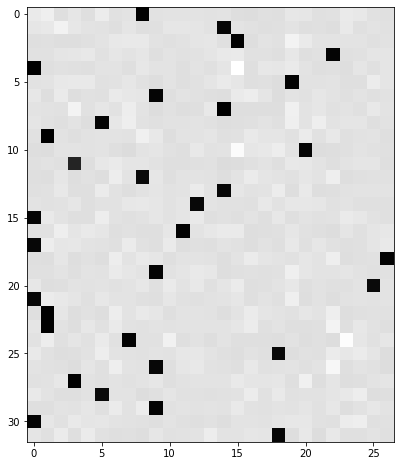

In [35]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

Each row in `dlogits` sums up to $0$ and has a value close to $-1$ at the position of the correct index. The gradients at each cell is like a force in which we're either pulling down on the probability of the incorrect characters or pushing up on the probability of the correct index. This is basically what is happening in each row. The amount of push and pull is exactly equalized because the sum of each row is $0$. Essentially, the repulsion and attraction forces are equal. 

The amount of force is proportional to the probabilities that came out in the forward pass. A perfectly correct probability prediction $-$ basically zeros everywhere except for 1 at the correct index/position: `[0, 0, 0, 1, 0, ..., 0]` $-$ will yield a `dlogits` row of all $0$ (no push and pull exists). Essentially, the amount to which your prediction is incorrect is exactly the amount by which you're going to get a push or pull in that dimension. <u>The amount to which you mispredict is proportional to the strength of the pull/push.</u> This happens independently in all the dimensions (row) of this tensor. This is the magic of the **cross-entropy loss** and its mechanism dynamically in the backward pass of the neural network.

---------
<br><br><a id="5"></a>
# 5.  Exercise 3: `BatchNorm` Layer Backward Pass
------ 

In [36]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [37]:
dhpreact.shape, (n*dhpreact).shape, bnraw.sum(0).shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([64]))

In [38]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
inside = n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)
dhprebn = bngain*bnvar_inv/n * inside
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


---------
<br><br><a id="6"></a>
# 6.  Exercise 4: Putting it all Together
------ 

In [44]:
# Exercise 4: putting it all together!
# Train the 2-layer MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        #loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        # YOUR CODE HERE :)

        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -=1
        dlogits /= n

        # 2nd linear layer backprop
        dh = dlogits @ W2.T # [32 27] * [27 64] -> [32 64]
        dW2 = h.T @ dlogits # [64 32] * [32 27] -> [64 27]
        db2 = dlogits.sum(0) # [32 27].sum(0) -> [27]

        # tanh layer backkprop
        dhpreact = (1.0 - h**2) * dh

        # batchnorm layer backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = (1.0 * dhpreact).sum(0, keepdim=True)
        _inside = n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)
        dhprebn = bngain*bnvar_inv/n * _inside

        # 1st linear layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)

        # embedding layer backprop
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

    #     if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #         break

12297
      0/ 200000: 3.7788
  10000/ 200000: 2.1985
  20000/ 200000: 2.3911
  30000/ 200000: 2.4683
  40000/ 200000: 1.9580
  50000/ 200000: 2.4058
  60000/ 200000: 2.3678
  70000/ 200000: 2.0933
  80000/ 200000: 2.3511
  90000/ 200000: 2.1526
 100000/ 200000: 1.9435
 110000/ 200000: 2.3060
 120000/ 200000: 2.0195
 130000/ 200000: 2.4472
 140000/ 200000: 2.3498
 150000/ 200000: 2.2027
 160000/ 200000: 1.9351
 170000/ 200000: 1.8581
 180000/ 200000: 2.0718
 190000/ 200000: 1.9001


In [45]:
#useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [46]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [47]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0723490715026855
val 2.109013319015503


The losses achieved:
* train: $\boldsymbol{2.072}$
* val: $\boldsymbol{2.109}$

In [48]:
# From tutorial: loss achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [49]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carlah.
ambrilli.
kimrix.
taty.
sacassie.
mahnen.
delynn.
jareei.
nellara.
chaiivon.
leigh.
ham.
join.
quinthorline.
liveni.
waythoniearisi.
jace.
pirsan.
edde.
oia.


---------
<br><br><a id="7"></a>
# 7. Conclusion
---

The summary of this notebook was to implement backpropagation manually to calculate the gradients for all the parameters of the neural network. Essentially, we build the full backpropagation through the neural network by hand step-by-step $-$ from the cross entropy loss, 2nd Linear layer, tanh layer, batchnorm layer, 1st Linear layer, to the embedding table $-$ instead of calling Pytorch autograd's `loss.backward()` function.

-----
<br><br>
# Appendix

------
## A1. Linear Layer Manual Backpropagation: Simpler Case<a id="a1"></a>
-----

Let's go through a simple case of `logits = h @ W2 + b2` which we can use to implement the 2nd linear layer gradients: `dh`, `dW2`, `db2`. This is also applicable to the 1st linear layer `hprebn = embcat @ W1 + b1` and its gradients: `dembcat`, `dW1`, `db1`. ![](_imgs/dh_dW2_db2_broadcasting3.png) 


------
## A2. Broadcasting Examples: Simpler Cases<a id="a2"></a>
-----

Apply for `dcounts_sum_inv`
```
probs = counts * counts_sum_inv

c = a * b, but with tensors
a[3 x 3] * b[3 x 1] ---> c[3 X 3]
|a11*b1 a12*b1 a13*b1|
|a21*b2 a22*b2 a23*b2|
|a31*b3 a32*b3 a33*b3|
```

Apply for `dcounts`
```
counts_sum = counts.sum(1, keepdims=True)
|a11 a12 a13|   ---> b1 (= a11 + a12 + a13)
|a21 a22 a23|   ---> b2 (= a21 + a22 + a23)
|a31 a32 a33|   ---> b3 (= a31 + a32 + a33)
```

Apply for `dlogits`
```
norm_logits = logits - logit_maxes
|c11 c12 c13|   = a11 a12 a13   b1
|c21 c22 c23|   = a21 a22 a23 - b2
|c31 c32 c33|   = a31 a32 a33   b3

so eg. c32 = a32 - b3
```

-----
<br><br><a id="r1"></a>
# References
----
1. "<u>Building makemore Part 4: Becoming a Backprop Ninja</u>" [youtube video](https://www.youtube.com/watch?v=q8SA3rM6ckI&t=6s), Oct 2022.
2. Andrej Karpathy **Makemore** [github repo](https://github.com/karpathy/makemore).
3. Andrej Karpathy  **Neural Networks: Zero to Hero** [github repo](https://github.com/karpathy/nn-zero-to-hero/tree/master) ([notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part4_backprop.ipynb) to follow video tutorial with).
4. Article: "<u>Become a Backprop Ninja with Andrej Karpathy</u>" - Kavishka Abeywardana, Pt [1](https://medium.com/@kdwa2404/become-a-backprop-ninja-with-andrej-karpathy-part-1-c0dab9867654), [2](https://medium.com/@kdwa2404/become-a-backprop-ninja-with-andrej-karpathy-part-2-e920cf3ea14c), March 2024.
5. "<u>Yes you should understand backprop</u>" - Andrej Karpathy, [article](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b), Dec 2016.
6. "<u>Bessel's Correction</u>" - Emory University Dept. of Mathematics & Computer Science, [academic blog](https://math.oxford.emory.edu/site/math117/besselCorrection/), Dec 2016.
------